In [378]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
import scipy as sci
from scipy import integrate
from scipy.integrate import solve_ivp
from astropy import units as u
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import astropy.constants as const
import math
import pickle

In [379]:
a_0 = 2.95 
b_0 = 0.596
mstar_tot = 1e11 * u.Msun
r_eff = (a_0*(mstar_tot/(1.e6*u.Msun))**b_0)* u.pc

print(r_eff)

# %%
m1 = 4e8 * u.Msun

rb = (m1/mstar_tot)**(1./3.)*r_eff
print("Binary radius is:", rb)
dyn_hard = (((rb/r_eff)**3)*r_eff).to(u.pc)
print(dyn_hard)


2817.2281287632354 pc
Binary radius is: 447.20708952331626 pc
11.268912515052946 pc


In [380]:
G = const.G.to(u.pc**3/(u.kg*u.yr**2)) #change the innate time to years
m_gal = 1e11 * const.M_sun
#Masses
m1=4e8 * const.M_sun #mass of black hole A
m2=4e8 * const.M_sun #mass of black hole B


sep = 430*u.pc
r1_initial=[((sep/2.).value),0,0] * u.pc
r2_initial=[-((sep/2.).value),0,0] * u.pc
#To arrays

r1=np.array(r1_initial,dtype="float64") * u.pc
r2=np.array(r2_initial,dtype="float64") * u.pc

#Semi-major axis
a = (0.5 * (sep))

#COM
r_com=(m1*r1+m2*r2)/(m1+m2)

#orbital veloctiy
# orb_v = (np.sqrt(const.G*(m1+m2)/a)).to(u.km/u.s) #added with Kris' source
# v = np.sqrt((const.G * (m1)) / r.to(u.m)).to(u.km/u.s)
v_circ = (np.sqrt((G*m1*(sep/2))/(sep)**2)).value
print(r1)
#V_i
v1_initial1=[0,v_circ, 0] *u.pc/u.yr
v2_inital1=[0,-v_circ,0] *u.pc/u.yr #km/s

v_df_fixed = (70 * u.km/u.s).to(u.pc/u.yr)
# v_df_fixed = ((90 * (np.sqrt(2)/2)) * u.km/u.s).to(u.pc/u.yr)
v1_df = np.array([0, v_df_fixed.value, 0])
v2_df = np.array([0, -v_df_fixed.value, 0])

#To arrays
v1=np.array(v1_initial1,dtype="float64") *u.pc/u.yr
v2=np.array(v2_inital1,dtype="float64") *u.pc/u.yr
#Find velocity of COM
v_com=(m1*v1+m2*v2)/(m1+m2)

#3 Gyr - 10 kpc
print(r_com)



[215.   0.   0.] pc
[0. 0. 0.] pc


In [381]:
def velocity_dispersion(m_gal_kg):
    """Calculate velocity dispersion in pc/yr — takes m_gal_kg in kg"""
    m_gal_ratio = m_gal_kg / (1e11 * const.M_sun.to(u.kg).value)
    v_kms = (10**2.2969) * (m_gal_ratio)**0.299  # km/s
    v_pcyr = (v_kms * (u.km/u.s)).to(u.pc/u.yr).value
    return v_pcyr


def coulomb_logarithm(r_com_pc, o_pcyr, G_val, m_val):
    """Calculate Coulomb logarithm, everything in floats"""
    x = (r_com_pc * o_pcyr**2) / (G_val * m_val)
    return math.log10(x)


def dynamical_friction_a(r_com_pc, v_rel_pcyr, ln_A, G_val, m_val):
    """Return dynamical friction acceleration, pc/yr^2"""
    v_mag = np.linalg.norm(v_rel_pcyr)
    unit_v = v_rel_pcyr / v_mag
    a_df_mag = 0.428 * ln_A * (G_val * m_val / r_com_pc**2)
    return -a_df_mag * unit_v


def calculate_DF(G_val, m1_val, m2_val, m_gal_val, r1_pc, r2_pc, v1_pcyr, v2_pcyr):
    """Calculate dynamical friction for both bodies"""
    r_com = (m1_val*r1_pc + m2_val*r2_pc) / (m1_val + m2_val)
    v_com = (m1_val*v1_pcyr + m2_val*v2_pcyr) / (m1_val + m2_val)

    o_pcyr = velocity_dispersion(m_gal_val)

    r1_com_pc = np.linalg.norm(r1_pc - r_com)
    r2_com_pc = np.linalg.norm(r2_pc - r_com)
    v1_rel_pcyr = v1_pcyr - v_com
    v2_rel_pcyr = v2_pcyr - v_com

    ln_A1 = coulomb_logarithm(r1_com_pc, o_pcyr, G_val, m1_val)
    ln_A2 = coulomb_logarithm(r2_com_pc, o_pcyr, G_val, m2_val)

    a_df1 = dynamical_friction_a(r1_com_pc, v1_rel_pcyr, ln_A1, G_val, m1_val)
    a_df2 = dynamical_friction_a(r2_com_pc, v2_rel_pcyr, ln_A2, G_val, m2_val)

    return a_df1, a_df2

In [382]:
orbital_period = np.sqrt((4 * (np.pi)**2 / (G * (m1)) * (a**3))).to(u.Myr)

print(orbital_period)
(20 * u.Myr).to(u.s)

14.766364899677814 Myr


<Quantity 6.31152e+14 s>

In [383]:
def dydt(t, y, m1, m2, G, m_gal, df_on=False):
    """
    Differential equations for two-body problem with optional dynamical friction.
    This version ensures DF evolves correctly by calculating it from instantaneous positions and velocities.
    """


    r1 = y[0:3]
    r2 = y[3:6]
    v1 = y[6:9]
    v2 = y[9:12]


    r12 = r2 - r1
    r12_mag = np.linalg.norm(r12)
    a1_grav = (G * m2 / r12_mag**3) * r12
    a2_grav = (G * m1 / r12_mag**3) * (-r12)


    a1_df = np.zeros(3)
    a2_df = np.zeros(3)
    if df_on:
        a1_df, a2_df = calculate_DF(G, m1, m2, m_gal, r1, r2, v1, v2)


    a1_total = a1_grav + a1_df
    a2_total = a2_grav + a2_df


    return np.concatenate([v1, v2, a1_total, a2_total])


In [384]:
t_i = 0.0  # yr
t_f = (20 * u.Myr).to(u.yr).value  # in yr
t_eval = np.linspace(t_i, t_f, 400)

G_val = G.value  # in pc^3 / (kg * yr^2)
m1_val = m1.to(u.kg).value
m2_val = m2.to(u.kg).value
m_gal_val = m_gal.value

In [385]:
y01 = np.concatenate([
    r1.to_value(u.pc),
    r2.to_value(u.pc),
    v1.to_value(u.pc/u.yr),
    v2.to_value(u.pc/u.yr)
])

y0_df = np.concatenate([
    r1.to_value(u.pc),
    r2.to_value(u.pc),
    v1_df,
    v2_df
])

print("Solving without DF...")
sol_no_df = solve_ivp(
    fun=lambda t, y: dydt(t, y, m1_val, m2_val, G_val, m_gal_val, df_on=False),
    t_span=(t_i, t_f),
    y0=y01,
    t_eval=t_eval,
    method='RK45',
    rtol=1e-8,
    atol=1e-8
)

print("Solving with DF...")
sol_df = solve_ivp(
    fun=lambda t, y: dydt(t, y, m1_val, m2_val, G_val, m_gal_val, df_on=True),
    t_span=(t_i, t_f),
    y0=y0_df,
    t_eval=t_eval,
    method='RK45',
    rtol=1e-8,
    atol=1e-8
)

Solving without DF...
Solving with DF...


In [386]:
def unpack_solution(sol):
    r1_ = sol.y[0:3].T  # shape (N, 3)
    r2_ = sol.y[3:6].T
    v1_ = sol.y[6:9].T
    v2_ = sol.y[9:12].T
    sep = np.linalg.norm(r1_ - r2_, axis=1)
    return r1_, r2_, v1_, v2_, sep

r1_nodf_arr, r2_nodf_arr, v1_nodf_arr, v2_nodf_arr, sep_nodf_arr = unpack_solution(sol_no_df)
r1_df_arr, r2_df_arr, v1_df_arr, v2_df_arr, sep_df_arr = unpack_solution(sol_df)


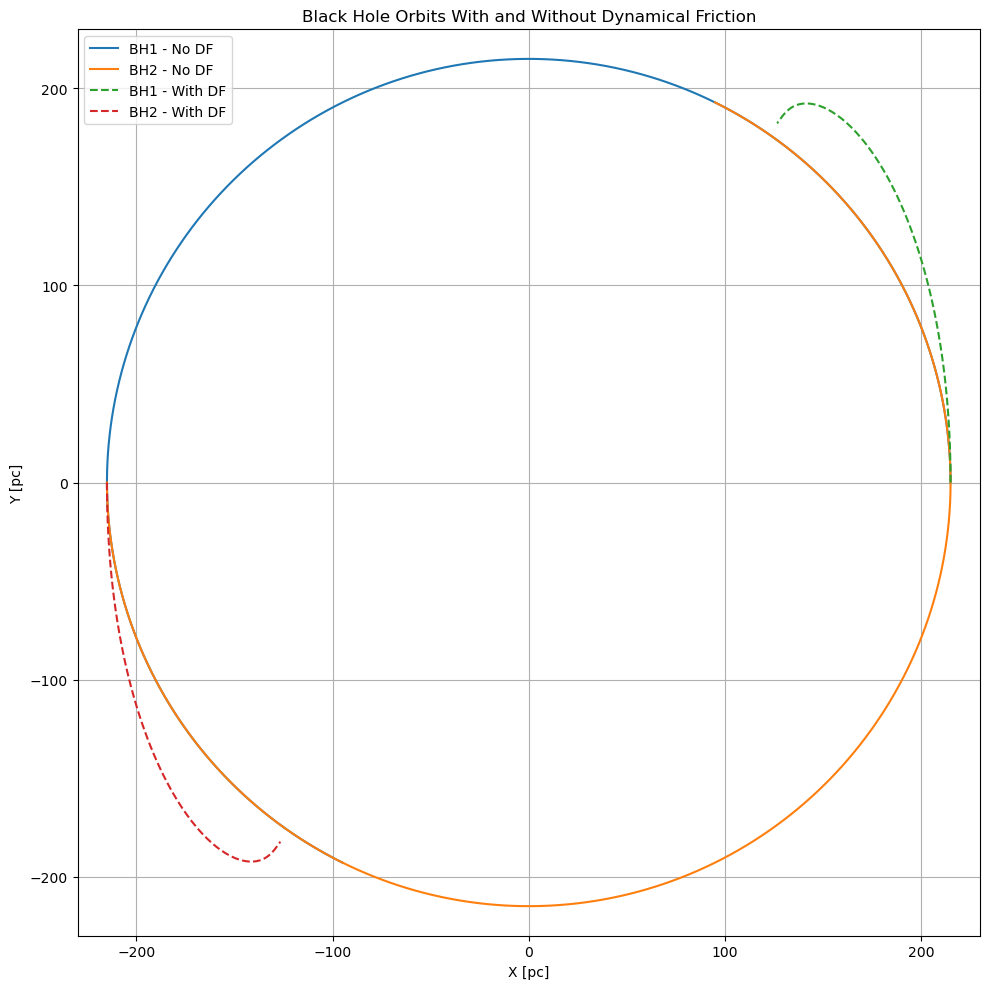

In [387]:
plt.figure(figsize=(10, 10))
plt.plot(r1_nodf_arr[:, 0], r1_nodf_arr[:, 1], label='BH1 - No DF')
plt.plot(r2_nodf_arr[:, 0], r2_nodf_arr[:, 1], label='BH2 - No DF')
plt.plot(r1_df_arr[:, 0], r1_df_arr[:, 1], label='BH1 - With DF', linestyle='--')
plt.plot(r2_df_arr[:, 0], r2_df_arr[:, 1], label='BH2 - With DF', linestyle='--')
plt.xlabel('X [pc]')
plt.ylabel('Y [pc]')
plt.title('Black Hole Orbits With and Without Dynamical Friction')
plt.legend()
plt.grid(True)
plt.ylim(-230, 230)
plt.xlim(-230,230)
plt.tight_layout()

# initial_conditions_text = (
#     f"Initial Conditions:\n"
#     f"BH A: Position: {r1_initial}, Velocity: {v1_df}\n"
#     f"BH B: Position: {r2_initial}, Velocity: {v2_df}\n"
#     f"Time: 0 to {t_f}"
# )
# plt.text(0.0, 0.5, initial_conditions_text, fontsize= 8, bbox=dict(boxstyle="round", facecolor="lightgray", alpha=0.9))
plt.show()

In [388]:
def compute_forces(G_, m1, m2, m_gal_, r1_arr, r2_arr, v1_arr, v2_arr, df_on=False):
    N = r1_arr.shape[0]
    a_grav1 = np.zeros((N, 3))
    a_grav2 = np.zeros((N, 3))
    a_df1 = np.zeros((N, 3))
    a_df2 = np.zeros((N, 3))
    a_total1 = np.zeros((N, 3))
    a_total2 = np.zeros((N, 3))

    for i in range(N):
        r1_ = r1_arr[i]
        r2_ = r2_arr[i]
        v1_ = v1_arr[i]
        v2_ = v2_arr[i]

        r12 = r2_ - r1_
        r12_mag = np.linalg.norm(r12)


        a1_grav = (G_ * m2 / r12_mag**3) * r12
        a2_grav = (G_ * m1 / r12_mag**3) * (-r12)


        a1_df = np.zeros(3)
        a2_df = np.zeros(3)
        if df_on:
            a1_df, a2_df = calculate_DF(G_, m1, m2, m_gal_, r1_, r2_, v1_, v2_)

        a_grav1[i] = a1_grav
        a_grav2[i] = a2_grav
        a_df1[i] = a1_df
        a_df2[i] = a2_df


        a_total1[i] = a1_grav + a1_df
        a_total2[i] = a2_grav + a2_df

    return a_grav1, a_grav2, a_df1, a_df2, a_total1, a_total2



a_grav1_nodf, a_grav2_nodf, a_df1_nodf, a_df2_nodf, a_tot1_nodf, a_tot2_nodf = compute_forces(
    G_val, m1_val, m2_val, m_gal_val,
    r1_nodf_arr, r2_nodf_arr, v1_nodf_arr, v2_nodf_arr, df_on=False
)


a_grav1_df, a_grav2_df, a_df1_df, a_df2_df, a_tot1_df, a_tot2_df = compute_forces(
    G_val, m1_val, m2_val, m_gal_val,
    r1_df_arr, r2_df_arr, v1_df_arr, v2_df_arr, df_on=True
)


In [389]:
speed1_nodf = np.linalg.norm(v1_nodf_arr, axis=1)
speed1_df = np.linalg.norm(v1_df_arr, axis=1)

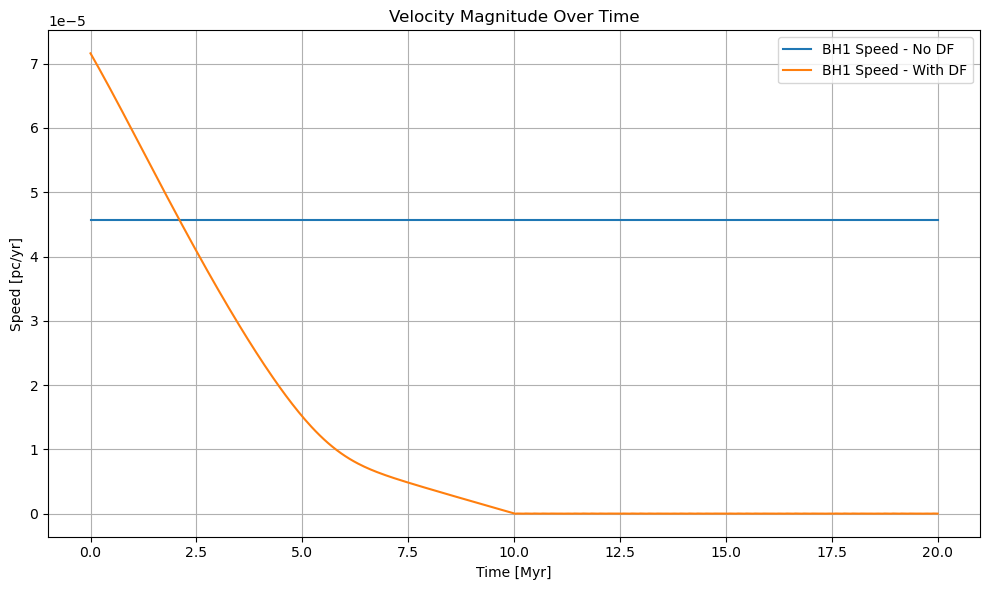

In [390]:
plt.figure(figsize=(10, 6))
plt.plot(t_eval[:len(speed1_nodf)] / 1e6, speed1_nodf, label='BH1 Speed - No DF') #same with this
plt.plot(t_eval[:len(speed1_df)] / 1e6, speed1_df, label='BH1 Speed - With DF')
plt.xlabel('Time [Myr]')
plt.ylabel('Speed [pc/yr]')
plt.title('Velocity Magnitude Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

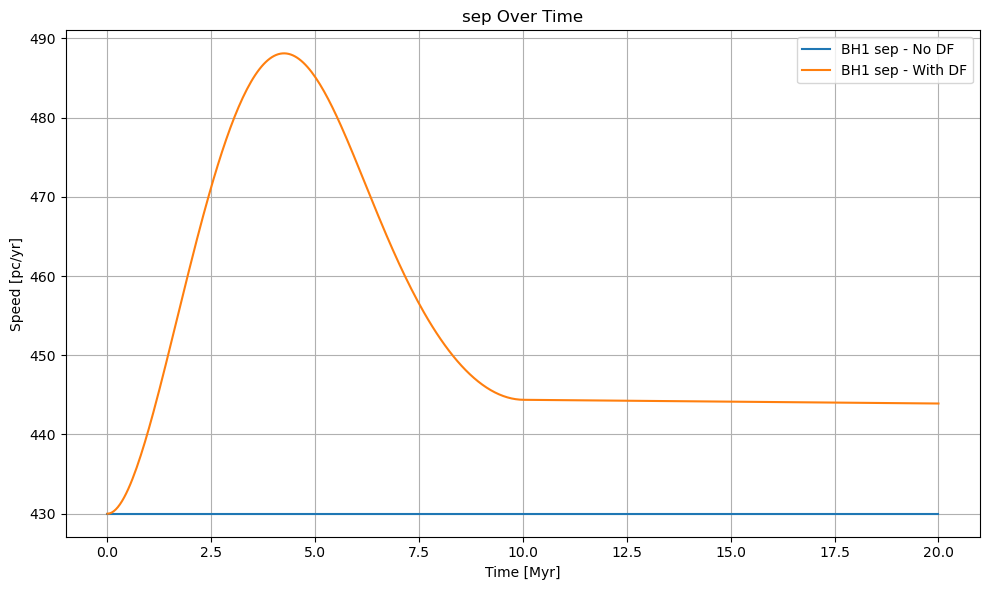

In [391]:
plt.figure(figsize=(10, 6))
plt.plot(t_eval[:len(sep_nodf_arr)] / 1e6, sep_nodf_arr, label='BH1 sep - No DF') #same with this
plt.plot(t_eval[:len(sep_df_arr)] / 1e6, sep_df_arr, label='BH1 sep - With DF')
plt.xlabel('Time [Myr]')
plt.ylabel('Speed [pc/yr]')
plt.title('sep Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [392]:
v1_nodf = ((v1_nodf_arr * u.pc / u.yr).to(u.km / u.s)).value
v2_nodf = ((v2_nodf_arr * u.pc / u.yr).to(u.km / u.s)).value
a_grav1_nodf_arr = ((a_grav1_nodf * u.pc / u.yr**2).to(u.km / u.s**2)).value
a_grav2_nodf_arr = ((a_grav2_nodf * u.pc / u.yr**2).to(u.km / u.s**2)).value
a_df1_nodf_arr = ((a_df1_nodf * u.pc / u.yr**2).to(u.km / u.s**2)).value
a_df2_nodf_arr = ((a_df2_nodf * u.pc / u.yr**2).to(u.km / u.s**2)).value
a_tot1_nodf_arr = ((a_tot1_nodf * u.pc / u.yr**2).to(u.km / u.s**2)).value
a_tot2_nodf_arr = ((a_tot2_nodf * u.pc / u.yr**2).to(u.km / u.s**2)).value

v1_df = ((v1_df_arr * u.pc / u.yr).to(u.km / u.s)).value
v2_df = ((v2_df_arr * u.pc / u.yr).to(u.km / u.s)).value
a_grav1_df_arr = ((a_grav1_df * u.pc / u.yr**2).to(u.km / u.s**2)).value
a_grav2_df_arr = ((a_grav2_df * u.pc / u.yr**2).to(u.km / u.s**2)).value
a_df1_df_arr = ((a_df1_df * u.pc / u.yr**2).to(u.km / u.s**2)).value
a_df2_df_arr = ((a_df2_df * u.pc / u.yr**2).to(u.km / u.s**2)).value
a_tot1_df_arr = ((a_tot1_df * u.pc / u.yr**2).to(u.km / u.s**2)).value
a_tot2_df_arr = ((a_tot2_df * u.pc / u.yr**2).to(u.km / u.s**2)).value


In [393]:
data_dict_nodf = {
    "r1": r1_nodf_arr,          
    "r2": r2_nodf_arr,          
    "v1": v1_nodf,          
    "v2": v2_nodf,          
    "sep": sep_nodf_arr,        
    "a_grav1": a_grav1_nodf_arr,    
    "a_grav2": a_grav2_nodf_arr,    
    "a_df1": a_df1_nodf_arr,        
    "a_df2": a_df2_nodf_arr,        
    "a_total1": a_tot1_nodf_arr,    
    "a_total2": a_tot2_nodf_arr,    
    "t": t_eval                 
}


data_dict_df = {
    "r1": r1_df_arr,
    "r2": r2_df_arr,
    "v1": v1_df,
    "v2": v2_df,
    "sep": sep_df_arr,
    "a_grav1": a_grav1_df_arr,
    "a_grav2": a_grav2_df_arr,
    "a_df1": a_df1_df_arr,
    "a_df2": a_df2_df_arr,
    "a_total1": a_tot1_df_arr,
    "a_total2": a_tot2_df_arr,
    "t": t_eval
}

In [394]:
# with open("functionsspeed6.pkl", "wb") as f:
#     pickle.dump(data_dict_nodf, f)

# with open("functionsspeed6_df.pkl", "wb") as f:
#     pickle.dump(data_dict_df, f)

In [431]:
delta_t = (5 * u.Myr).to(u.yr)  
c = 1  

r1 = np.array([215, 0, 0]) * u.pc
r2 = np.array([-215, 0, 0]) * u.pc
v_df_fixed = (70 * u.km/u.s).to(u.pc/u.yr)
v1_df_test = np.array([0, v_df_fixed.value, 0]) * u.pc / u.yr
v2_df_test = np.array([0, -v_df_fixed.value, 0]) * u.pc / u.yr



m1 = 1e8 * u.Msun
m2 = 1e8 * u.Msun
m_gal = 1e11 * u.Msun


r = np.linalg.norm(r2 - r1) 
r1_com = np.linalg.norm(r1)  

sigma = ((10 ** (2.2969)) * (m_gal / (1e11 * u.Msun)) ** (0.299)) * (u.km / u.s)


x1 = (r1_com * sigma**2) / (G * m1)
ln_A1 = math.log(x1.to_value(u.dimensionless_unscaled))

v_rel1 = v1_df_test - v2_df_test
v_rel2 = v2_df_test - v1_df_test


v_dir1 = v_rel1 / np.linalg.norm(v_rel1)
v_dir2 = v_rel2 / np.linalg.norm(v_rel2)


F_D1 = (0.428 * ln_A1 * (G * m1**2) / r1_com**2).to(u.N)  
a_D1 = (F_D1 / m1).to(u.km / u.s**2) * -v_dir1
a_D2 = (F_D1 / m1).to(u.km / u.s**2) * -v_dir2  


grav_acc1 = (G * m2 * (r2 - r1) / r**3).to(u.km / u.s**2)
grav_acc2 = (-G * m1 * (r2 - r1) / r**3).to(u.km / u.s**2)


dv1bydt = (grav_acc1 + (c * a_D1)).to(u.pc / u.yr**2)
dv2bydt = (grav_acc2 + (c * a_D2)).to(u.pc/u.yr**2)
print(v1_df)
print(dv1bydt)
print(delta_t)


v1_df_test += dv1bydt * (delta_t)
v2_df_test += dv2bydt * (delta_t)

print(v1_df)

r1 += v1_df_test * delta_t
r2 += v2_df_test * delta_t


print(v1, v2, r1, r2)

[-1.21646894e-05  9.60142382e-06  0.00000000e+00] pc / yr
[-2.43293789e-12 -1.23976855e-11  0.00000000e+00] pc / yr2
5000000.0 yr
[-1.21646894e-05  9.60142382e-06  0.00000000e+00] pc / yr
[0.00000000e+00 4.57419565e-05 0.00000000e+00] pc / yr [ 0.00000000e+00 -4.57419565e-05  0.00000000e+00] pc / yr [154.17655285  48.0071191    0.        ] pc [-154.17655285  -48.0071191     0.        ] pc


In [432]:
# r = np.linalg.norm(r2 - r1) 
# r1_com = np.linalg.norm(r1)  

# sigma = ((10 ** (2.2969)) * (m_gal / (1e11 * u.Msun)) ** (0.299)) * (u.km / u.s)


# x1 = (r1_com * sigma**2) / (G * m1)
# ln_A1 = math.log(x1.to_value(u.dimensionless_unscaled))

# v_rel1 = v1_df - v2_df
# v_rel2 = v2_df - v1_df


# v_dir1 = v_rel1 / np.linalg.norm(v_rel1)
# v_dir2 = v_rel2 / np.linalg.norm(v_rel2)


# F_D1 = (0.428 * ln_A1 * (G * m1**2) / r1_com**2).to(u.N)  
# a_D1 = (F_D1 / m1).to(u.km / u.s**2) * -v_dir1
# a_D2 = (F_D1 / m1).to(u.km / u.s**2) * -v_dir2  


# grav_acc1 = (G * m2 * (r2 - r1) / r**3).to(u.km / u.s**2)
# grav_acc2 = (-G * m1 * (r2 - r1) / r**3).to(u.km / u.s**2)


# dv1bydt = (grav_acc1 + (c * a_D1)).to(u.pc / u.yr**2)
# dv2bydt = (grav_acc2 + (c * a_D2)).to(u.pc/u.yr**2)

In [438]:
t_eval.shape

(400,)

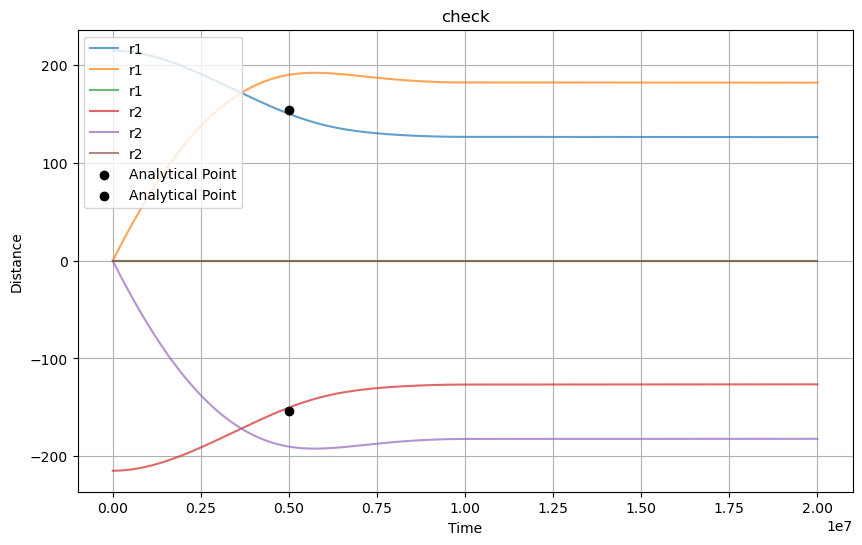

In [439]:

plt.figure(figsize=(10, 6))
plt.plot(t_eval, r1_df_arr, label="r1", alpha=0.7)
plt.plot(t_eval, r2_df_arr, label="r2", alpha=0.7)

# Plot analytic point
plt.scatter(delta_t, r1[0], color='black', label='Analytical Point', zorder=5)
plt.scatter(delta_t, r2[0], color='black', label='Analytical Point', zorder=5)


plt.xlabel("Time")
plt.ylabel("Distance")
plt.title("check")
plt.legend()
plt.grid(True)
plt.show()